In [1]:
import numpy as np
import sys
import scipy.stats as st
import matplotlib.pyplot as plt
from pathlib import Path
# setting path
sys.path.append('../topotests/')
sys.path.append('../multiKS/')
from topotests import TopoTest
from distributions import MultivariateDistribution, GaussianMixture, AbsoluteDistribution
from multiKS import multiKS
import pandas as pd
from concurrent.futures import ProcessPoolExecutor
from functools import partial
import datetime
import sys, getopt
import scipy

In [2]:
from ecc import *
import scipy.interpolate as spi

In [4]:
rv = MultivariateDistribution([st.norm(), st.norm(), st.norm()], label='N01xN01xN01')
#rv = MultivariateDistribution([st.beta(2,2), st.beta(2,2), st.beta(2,2)], label='B22xB22xB22')

In [ ]:
ns = [50, 100, 300, 500, 1000]
res = []
for n in ns:
    print(f'n={n}')
    for mc in range(500):
        ds = []
        X1 = rv.rvs(n)
        X2 = rv.rvs(n)

        ecc1 = np.array(compute_ECC_contributions_alpha(X1))
        ecc1[:, 1] = np.cumsum(ecc1[:, 1])

        ecc2 = np.array(compute_ECC_contributions_alpha(X2))
        ecc2[:, 1] = np.cumsum(ecc2[:, 1])

        xgrid = np.linspace(0, np.min([ecc1[-1, 0], ecc2[-1, 0]]), 2000)

        interpolator = spi.interp1d(ecc1[:, 0], ecc1[:, 1], kind='previous')
        y1 = interpolator(xgrid)
        interpolator = spi.interp1d(ecc2[:, 0], ecc2[:, 1], kind='previous')
        y2 = interpolator(xgrid)

        d = np.max(np.abs(y1-y2))

        ds.append(d)
    res.append([n, np.quantile(ds, 0.95)])

In [44]:
#res_B = np.array(res)

In [48]:
res_N = np.array(res)

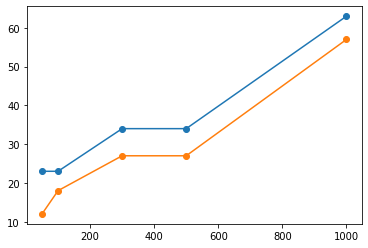

In [49]:
res = np.array(res)
plt.plot(res_N[:, 0], res_N[:, 1], 'o-')
plt.plot(res_B[:, 0], res_B[:, 1], 'o-')

In [203]:
def get_ecc(X, standarize=True):
    n = len(X)
    ecc = np.array(compute_ECC_contributions_alpha(X))
    ecc[:, 1] = np.cumsum(ecc[:, 1])
    if standarize:
        ecc[:, 1] = ecc[:, 1]/n
        ecc[:, 0] = ecc[:, 0]*n
    return ecc

ds = []

rv = MultivariateDistribution([st.beta(2,2), st.beta(2,2), st.beta(2,2)], label='B22xB22xB22')

for mc in range(100):
    X1 = rv.rvs(n)
    X2 = rv.rvs(n)
    X12 = np.vstack([X1, X2])
    ecc1 = get_ecc(X1)
    ecc2 = get_ecc(X2)
    ecc12 = get_ecc(X12)
    xgrid = np.linspace(0, np.min([ecc1[-1, 0], ecc2[-1, 0], ecc12[-1, 0]]), 2000)

    interpolator = spi.interp1d(ecc1[:, 0], ecc1[:, 1], kind='previous')
    y1 = interpolator(xgrid)
    interpolator = spi.interp1d(ecc2[:, 0], ecc2[:, 1], kind='previous')
    y2 = interpolator(xgrid)
    interpolator = spi.interp1d(ecc12[:, 0], ecc12[:, 1], kind='previous')
    y12 = interpolator(xgrid)

    d1 = np.max(np.abs(y1-y12))
    d2 = np.max(np.abs(y2-y12))
    
    ds.append([d1, d2, d1-d2, np.abs(d1-d2)])

ds = np.array(ds)
np.quantile(ds, q=0.95, axis=0)
#plt.plot(ecc1[:, 0], ecc1[:, 1])
#plt.plot(ecc2[:, 0], ecc2[:, 1])
#plt.xlim((0, 50))

array([0.3405 , 0.32525, 0.121  , 0.15025])

In [199]:
np.quantile(ds, q=0.95, axis=0)

array([0.1455 , 0.145  , 0.04525, 0.06025])

In [73]:
def secondmin(arr):
    sublist = [x for x in arr if x > min(arr)]
    return min(sublist)

def distances(X):
    dmin = []
    davg = []
    for x in X:
        dmin.append(secondmin(np.linalg.norm(X-x, axis=1)))
        davg.append(np.mean(np.linalg.norm(X-x, axis=1))) #this contains 0
    return np.mean(dmin), np.mean(davg)

In [119]:
rv = MultivariateDistribution([st.norm(), st.norm()], label='N01xN01xN01')
ns = [10, 25, 50, 100, 200, 300, 500, 750, 1000, 1500]
dist = []
for n in ns:
    X = rv.rvs(n)
    dist.append([n, *distances(X)])

dist = np.array(dist)

      fun: 0.003724445136812218
 hess_inv: array([[65.13615771, -5.40805114],
       [-5.40805114,  0.48773117]])
      jac: array([ 1.50757842e-08, -6.82834070e-07])
  message: 'Optimization terminated successfully.'
     nfev: 45
      nit: 12
     njev: 15
   status: 0
  success: True
        x: array([ 3.87652961, -0.60821548])


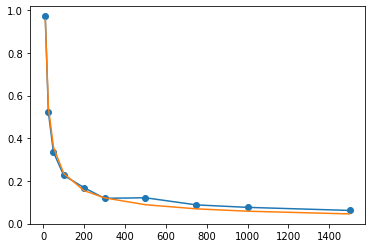

In [120]:
def _f(param):
    y = param[0]*dist[:, 0]**param[1]
    return np.sum((y-dist[:, 1])**2)

res = scipy.optimize.minimize(_f, [1, -1/3])
print(res)
y = res.x[0]*dist[:, 0]**res.x[1]
plt.plot(dist[:, 0], dist[:, 1], 'o-')
plt.plot(dist[:, 0], y)

In [ ]:
# Niklas idea

In [3]:
def get_ecc(X, xgrid, standarize=True):
    n = len(X)
    xmax = np.max(xgrid)
    ecc = np.array(compute_ECC_contributions_alpha(X))
    ecc[:, 1] = np.cumsum(ecc[:, 1])
    ecc = np.vstack([ecc, [xmax, 1]])
    if standarize:
        ecc[:, 1] = ecc[:, 1]/n
        ecc[:, 0] = ecc[:, 0]*n
    interpolator = spi.interp1d(ecc[:, 0], ecc[:, 1], kind='previous')
    ecc = interpolator(xgrid)
    return ecc

def dist_ecc(ecc1, ecc2):
    return np.max(np.abs(ecc1-ecc2))

In [29]:
rv_norm = MultivariateDistribution([st.norm(), st.norm(), st.norm()], label='N01xN01xN01')
rv_beta = MultivariateDistribution([st.beta(2,2), st.beta(2,2), st.beta(2,2)], label='B22xB22xB22')
rv_bnu = MultivariateDistribution([st.beta(2,2), st.norm(), st.uniform()], label='B22xN01xU01')


rv = rv_norm

In [ ]:
# MACIERZ ODLEGLOSCI
# WARTOSC GRANICZNA WYZNACZANA Z MACIERZY ODEGLOSCI

n = 1000
replace = False
xgrid = np.linspace(0, 3, 1000)
mcloops_emp = 200
rejected = 0
distances = []
for loop_emp in range(mcloops_emp):
    if loop_emp % 10 == 0:
        print(f'loop_emp = {loop_emp} rejected={rejected}')
    X1 = rv.rvs(n)
    X2 = rv.rvs(n)
    ecc1 = get_ecc(X1, xgrid=xgrid, standarize=False)
    ecc2 = get_ecc(X2, xgrid=xgrid, standarize=False)
    mcloops = 200
    X12 = np.vstack([X1, X2])
    eccs = []
    for _ in range(mcloops):
        X1_ = X1[np.random.choice(n, int(n/2), replace=replace)]
        X2_ = X2[np.random.choice(n, int(n/2), replace=replace)]
        X = np.vstack([X1_, X2_])
        y = get_ecc(X, xgrid=xgrid, standarize=False)
        eccs.append(y)
    eccs = np.array(eccs)
    dist = []
    for row in range(mcloops-1):
        for col in range(row+1, mcloops):
            dist.append(dist_ecc(eccs[row, :], eccs[col, :]))
    threshold = np.quantile(dist, q=1-0.5*0.1)
    dist_samples = dist_ecc(ecc1, ecc2)
    distances.append([dist_samples, threshold])
    if dist_samples > threshold:
        rejected = rejected + 1
print(rejected/mcloops_emp)

In [31]:
# TEST PERMUTACYJNY

n = 100
replace = False
xgrid = np.linspace(0, 3, 1000)
mcloops_emp = 200

pvals = []
for loop_emp in range(mcloops_emp):
    if loop_emp % 10 == 0:
        print(f'loop_emp = {loop_emp}')
    # X1 = rv.rvs(n)
    # X2 = rv.rvs(n)
    X1 = rv_norm.rvs(n)
    X2 = rv_beta.rvs(n)
    ecc1 = get_ecc(X1, xgrid=xgrid, standarize=False)
    ecc2 = get_ecc(X2, xgrid=xgrid, standarize=False)
    D = dist_ecc(ecc1, ecc2)
    X12 = np.vstack([X1, X2])
    distances = []
    mcloops = 300
    nhalf = int(n/2)
    for _ in range(mcloops):
        # zmienic tak zeby losowanie bylo z obu prob
        inds1 = np.random.permutation(n)
        inds2 = np.random.permutation(n)
        X1_ = X1[inds1[:nhalf]]
        X2_ = X2[inds1[:nhalf]]
        X = np.vstack([X1_, X2_])
        y0 = get_ecc(X, xgrid=xgrid, standarize=False)
        X1_ = X1[inds1[nhalf:]]
        X2_ = X2[inds1[nhalf:]]
        X = np.vstack([X1_, X2_])
        y1 = get_ecc(X, xgrid=xgrid, standarize=False)
        distances.append(dist_ecc(y0, y1))
    pval = np.sum(distances > D)/mcloops
    pvals.append(pval)

loop_emp = 0
loop_emp = 10
loop_emp = 20
loop_emp = 30
loop_emp = 40
loop_emp = 50
loop_emp = 60
loop_emp = 70
loop_emp = 80
loop_emp = 90
loop_emp = 100
loop_emp = 110
loop_emp = 120
loop_emp = 130
loop_emp = 140
loop_emp = 150
loop_emp = 160
loop_emp = 170
loop_emp = 180
loop_emp = 190


In [ ]:
pvals = np.array(pvals)
for alpha in [0.01, 0.05, 0.1, 0.2]:
    prop = np.sum(pvals < alpha)/len(pvals)
    print(f'alpha={alpha} prop={prop}')